<a href="https://colab.research.google.com/github/miaonaise/swedbank_case/blob/main/CREDIT_RISK_SWEDBANK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
# Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change current working directory
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Swedbank_case/')

Mounted at /content/gdrive


### **Read Data**

In [ ]:
# Read data

df = pd.read_csv('case_data.csv',sep=',')
df = df.rename(columns={'x1': 'Credit amount','x2':'Gender','x2.1':'Education','x4':'Marital status','x5':'Age','x24':'Income in application','Default next month ':'Default next month'})
print("Initial size of data: ",len(df))

Initial size of data:  30022


In [ ]:
df.head()

,Cust_id,Credit amount,Gender,Education,Marital status,Age,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,Income in application,Default next month
0,1,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,79183.0,1.0
1,2,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,29743.0,1.0
2,3,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,34786.0,0.0
3,4,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,41860.0,0.0
4,5,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,60325.0,0.0


In [ ]:
df.describe()

### **Data preprocessing**

In [ ]:
# CLEAN DATA

# Remove missing data
df = df.dropna()

# Remove data points with mistakes
df = df[df['Default next month'].isin([0,1])]
df = df[df['Income in application'] > 10000]
df = df[df['Gender'].isin([1,2])]
df = df[df['Marital status'].isin([1,2,3])]
df = df[df['Education'].isin([1,2,3,4])]
df = df[df['Credit amount'] > 0]

print("Data size after cleaning: ",len(df))

Data size after cleaning:  29599


In [ ]:
# Split features X and response y

full_features = df.iloc[:, :-1]
response = df['Default next month']


# Scale bill statements and repayments with credit amount

# Copy and pasting because when I try to change all together the session crashes due to little RAM...
# Warning: do not run more than once. 
full_features['x12'] = full_features['x12']/full_features['Credit amount']
full_features['x13'] = full_features['x13']/full_features['Credit amount']
full_features['x14'] = full_features['x14']/full_features['Credit amount']
full_features['x15'] = full_features['x15']/full_features['Credit amount']
full_features['x16'] = full_features['x16']/full_features['Credit amount']
full_features['x17'] = full_features['x17']/full_features['Credit amount']
full_features['x18'] = full_features['x18']/full_features['Credit amount']
full_features['x19'] = full_features['x19']/full_features['Credit amount']
full_features['x20'] = full_features['x20']/full_features['Credit amount']
full_features['x21'] = full_features['x21']/full_features['Credit amount']
full_features['x22'] = full_features['x22']/full_features['Credit amount']
full_features['x23'] = full_features['x23']/full_features['Credit amount']
full_features['Income in application'] = full_features['Income in application']/full_features['Credit amount']


# Adding some customized features

# Aggregating the repayment status, bill statements and repayment amounts over ALL MONTHS
full_features['repay_status_sum'] = full_features['x6'] + full_features['x7'] + full_features['x8'] + full_features['x9'] + full_features['x10'] + full_features['x11']
full_features['bill_state_sum'] = full_features['x12'] + full_features['x13'] + full_features['x14'] + full_features['x15'] + full_features['x16'] + full_features['x17']
full_features['repayment_sum'] = full_features['x18'] + full_features['x19'] + full_features['x20'] + full_features['x21'] + full_features['x22'] + full_features['x23']

# Aggregating the repayment status, bill statements and repayment amounts over LATEST TWO MONTHS
full_features['repay_status_sum2'] = full_features['x6'] + full_features['x7']
full_features['bill_state_sum2'] = full_features['x12'] + full_features['x13']
full_features['repayment_sum2'] = full_features['x18'] + full_features['x19']

# Number of zero bill statements
full_features['num_of_zero_bills'] = (df['x12'] == 0).astype(int) + (df['x13'] == 0).astype(int) + (df['x14'] == 0).astype(int) + (df['x15'] == 0).astype(int) + (df['x16'] == 0).astype(int) + (df['x17'] == 0).astype(int)

# Average repayment ratio
# I want to look at non-linear relationships between the features, however this one is very faulty and needs to be scaled in a much better way. 
bills = full_features['x13'] + full_features['x14'] + full_features['x15'] + full_features['x16'] + full_features['x17']
repays = full_features['x18'] + full_features['x19'] + full_features['x20'] + full_features['x21'] + full_features['x22']
full_features['average_repayment_ratio'] = repays/bills
full_features.replace(np.inf, 1, inplace=True)


### **Observations and Data visualization**

In [ ]:
# No bill payments in the past 6 months all have repayment status -2.0 for 5 months, 
# but in september 2005 it is either 1.0 or -2.0. Why? Not consistent with default probability either.
inactive = df[df['x12']+df['x13']+df['x14']+df['x15']+df['x16']+df['x17']==0][df['x7']+df['x8']+df['x9']+df['x10']+df['x11'] == -10]
inactive.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Cust_id,Credit amount,Gender,Education,Marital status,Age,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,Income in application,Default next month
18,19,360000.0,2.0,1.0,1.0,49.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63569.0,0.0
19,20,180000.0,2.0,1.0,2.0,29.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48686.0,0.0
45,46,210000.0,1.0,1.0,2.0,29.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63060.0,1.0
79,80,240000.0,2.0,2.0,2.0,44.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87713.0,1.0
121,122,450000.0,1.0,1.0,1.0,40.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38321.0,1.0
122,123,110000.0,2.0,1.0,1.0,48.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73901.0,0.0
125,126,20000.0,1.0,2.0,2.0,23.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84836.0,0.0
140,141,240000.0,1.0,1.0,2.0,47.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38122.0,1.0
272,273,260000.0,2.0,1.0,2.0,58.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81613.0,1.0
274,275,360000.0,2.0,2.0,2.0,28.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31458.0,1.0


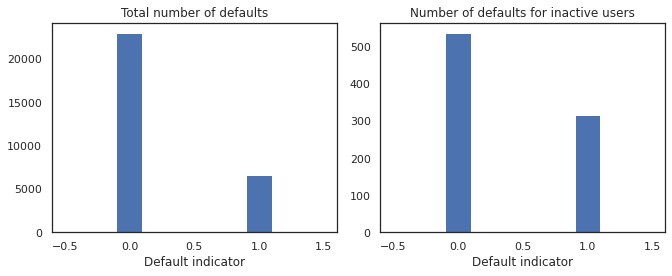

In [ ]:
# Number of defaults
fig, ((ax0), (ax1)) = plt.subplots(nrows=1, ncols=2,figsize=(9.5,4))

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

ax0.hist(df['Default next month'],histtype='bar', range = (-0.5,1.5))
ax0.set_xlabel('Default indicator')
ax0.set_title('Total number of defaults')

ax1.hist(inactive['Default next month'], histtype='bar', range = (-0.5,1.5))
ax1.set_xlabel('Default indicator')
ax1.set_title('Number of defaults for inactive users')
fig.tight_layout()
plt.show()

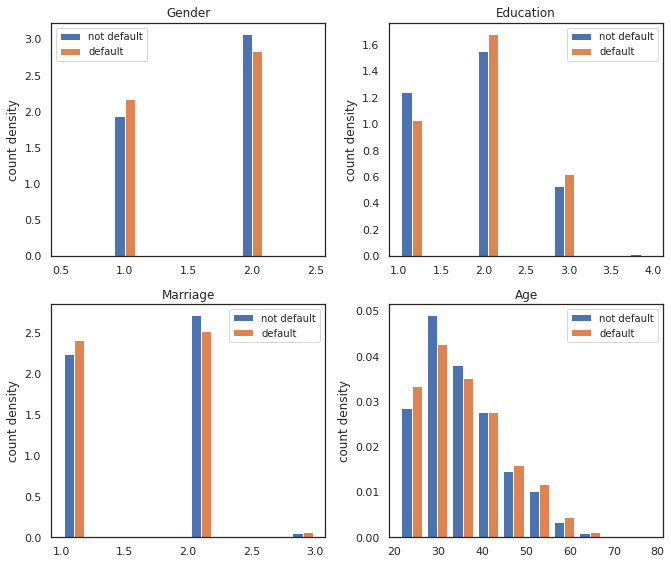

In [ ]:
# Visualization of default indicator against Gender, Education, Marital status and Age

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2,figsize=(9.5,8))

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

ax0.hist([df['Gender'][df['Default next month'] == 0],df['Gender'][df['Default next month'] == 1]],
         histtype='bar', label=['not default','default'],range = (0.5,2.5),density=True)
ax0.legend(prop={'size': 10})
ax0.set_ylabel('count density')
ax0.set_title('Gender')

ax1.hist([df['Education'][df['Default next month'] == 0],df['Education'][df['Default next month'] == 1]],
         histtype='bar', label=['not default','default'],density=True)
ax1.legend(prop={'size': 10})
ax1.set_ylabel('count density')
ax1.set_title('Education')

ax2.hist([df['Marital status'][df['Default next month'] == 0],df['Marital status'][df['Default next month'] == 1]],
         histtype='bar', label=['not default','default'],density=True)
ax2.legend(prop={'size': 10})
ax2.set_ylabel('count density')
ax2.set_title('Marriage')

ax3.hist([df['Age'][df['Default next month'] == 0],df['Age'][df['Default next month'] == 1]],
         histtype='bar', label=['not default','default'],density=True)
ax3.legend(prop={'size': 10})
ax3.set_ylabel('count density')
ax3.set_title('Age')

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'latest bill statement')

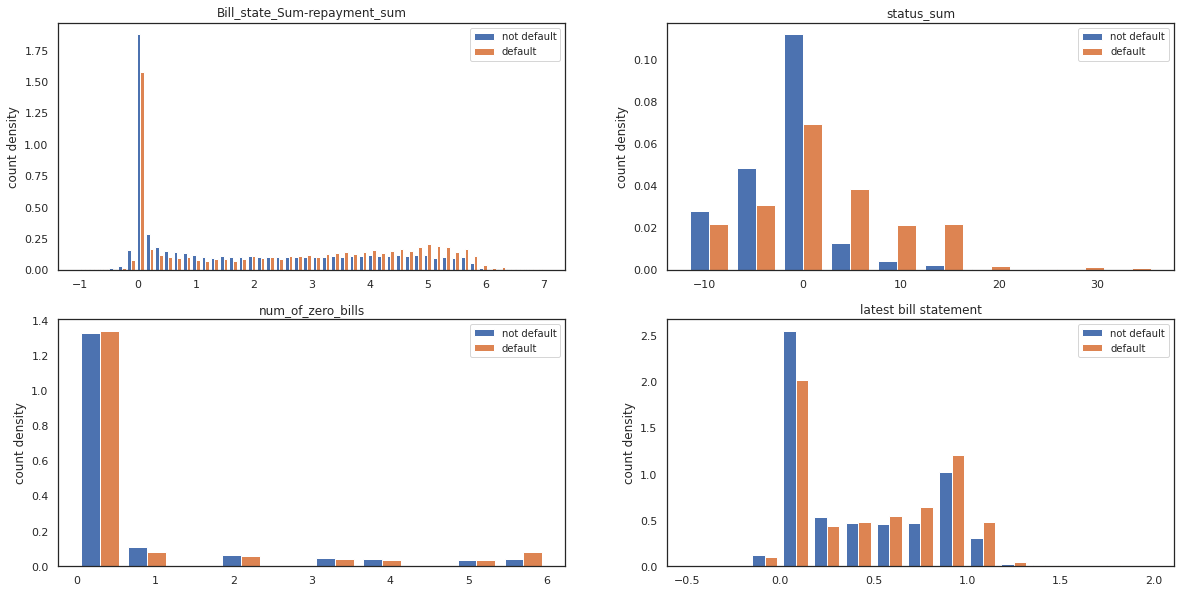

In [ ]:
# Visualization of aggregated scaled pay against default indicator
fig, ((ax0,ax1), (ax2,ax3)) = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

owe = full_features['bill_state_sum'] - full_features['repayment_sum']
owe_alive = owe[df['Default next month'] == 0]
owe_default = owe[df['Default next month'] == 1]

ratio = owe_alive/owe_default

ax0.hist([owe_alive,owe_default],
         histtype='bar', label=['not default','default'],bins = 50,range = (-1,7),density=True)
ax0.legend(prop={'size': 10})
ax0.set_ylabel('count density')
ax0.set_title('Bill_state_Sum-repayment_sum')

ax1.hist([full_features['repay_status_sum'][df['Default next month'] == 0],full_features['repay_status_sum'][df['Default next month'] == 1]],
         label=['not default','default'],density=True)
ax1.legend(prop={'size': 10})
ax1.set_ylabel('count density')
ax1.set_title('status_sum')

ax2.hist([full_features.num_of_zero_bills[df['Default next month']==0],full_features.num_of_zero_bills[df['Default next month']==1]],
         histtype='bar', label=['not default','default'],range = (0,6),density=True)
ax2.legend(prop={'size': 10})
ax2.set_ylabel('count density')
ax2.set_title('num_of_zero_bills')

ax3.hist([full_features.x12[df['Default next month']==0],full_features.x12[df['Default next month']==1]],
         histtype='bar', label=['not default','default'],range = (-0.5,2),bins = 15,density=True)
ax3.legend(prop={'size': 10})
ax3.set_ylabel('count density')
ax3.set_title('latest bill statement')



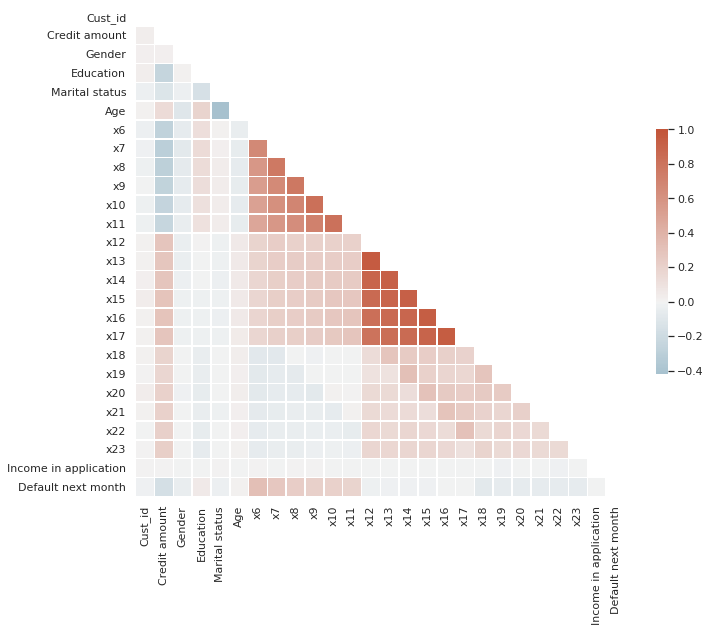

In [ ]:
# Visualization of correlation

sns.set_theme(style="white")

d = df
corr = d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

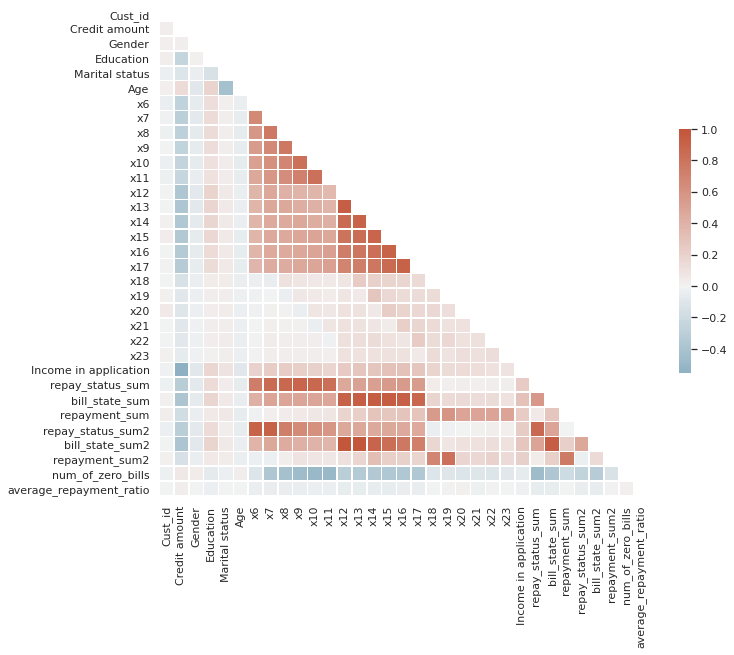

In [ ]:
# Visualization of full_features correlation

sns.set_theme(style="white")

d = full_features
corr = d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### **Feature processing**

In [ ]:
# Choose categorical featres and one hot encoding

categorical = full_features[['Gender','Education','Marital status']]
enc = OneHotEncoder(handle_unknown='error')
enc.fit(categorical)
encoded_categorical = enc.transform(categorical).toarray()

In [ ]:
# PCA

# This section is not used, only there to attempt PCA
# PCA does not affect the accuracy singificantly. Therefore PCA is not used because the tradeoff for intrepetability is not worth it.
PCA_features = ['x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23']
pca = PCA()
PCA_encoded = pca.fit_transform(full_features[PCA_features])
print(pca.singular_values_)
# adjust n_components based on singular values
pca = PCA(n_components=7)
PCA_encoded = pca.fit_transform(full_features[PCA_features])
print(np.shape(PCA_encoded))

In [ ]:
# Choose non-categorical and non-PCA features

#feature_selection = ['Age','Credit amount','Income in application','repay_status_sum2','bill_state_sum2','repayment_sum2','repay_status_sum','bill_state_sum','repayment_sum']
#feature_selection = ['Credit amount','Income in application','repay_status_sum2','bill_state_sum2','repayment_sum2','repay_status_sum','bill_state_sum','repayment_sum','num_of_zero_bills']
select_all = ['Gender','Education','Marital status','Age','Credit amount','Income in application','x6','x12','x18','repay_status_sum','bill_state_sum','repayment_sum','num_of_zero_bills']
feature_selection = ['Credit amount','Income in application','x6','x12','x18','repay_status_sum','bill_state_sum','repayment_sum','num_of_zero_bills']

### **Feature importance analysis**

In [ ]:
# Select ALL features and inspect feature importances obtained from the models

select_all = ['Gender','Education','Marital status','Age','Credit amount','Income in application','x6','x12','x18','repay_status_sum','bill_state_sum','repayment_sum','num_of_zero_bills']
y = np.array(response)
X = np.array(full_features[select_all])
#X = np.concatenate((encoded_categorical,X),axis = 1)
#X = np.concatenate((encoded_categorical,PCA_encoded,X),axis = 1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True)

**Logistic Regression**

In [ ]:
# logistic Regression
clf_logistic = LogisticRegression(random_state=0,multi_class = 'ovr',max_iter = 100, solver = 'newton-cg')
clf_logistic.fit(X_train,y_train)
y_pred = clf_logistic.predict(X_test)
AUC = roc_auc_score(y_test,y_pred)

# Automatic feature selection, used recursively
sel = SelectFromModel(clf_logistic)
sel.fit(X_train, y_train)
sel.get_support()
tehhe = np.where(sel.get_support()== True)[0].astype(int)
selected_features = [select_all[i] for i in tehhe]

Test accuracy of Logistic Regression:  0.8091216216216216
ROC AUC scores 0.6207675305327559
Automatic selected important features of Logistic Regression:  ['x6', 'x12', 'x18', 'repayment_sum', 'num_of_zero_bills']


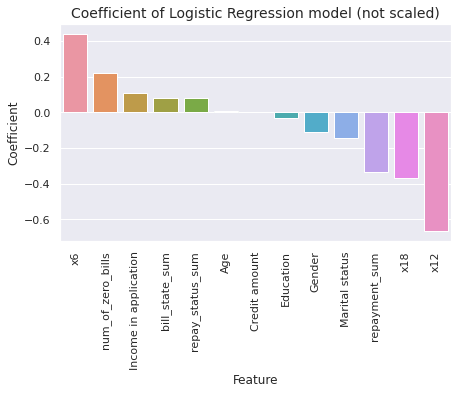

In [ ]:
print("Test accuracy of Logistic Regression: ",accuracy_score(y_test,y_pred))
print("ROC AUC scores",AUC)
print("Automatic selected important features of Logistic Regression: ", selected_features)

# Keep in mind that the coefficients aren't scaled to the value size
tmp = pd.DataFrame({'Feature': select_all, 'Coefficient': clf_logistic.coef_[0]})
tmp = tmp.sort_values(by='Coefficient',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Coefficient of Logistic Regression model (not scaled)',fontsize=14)
s = sns.barplot(x='Feature',y='Coefficient',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

**Random Forest**

Test accuracy of Random Forest:  0.822972972972973
ROC AUC scores 0.6699923844396409
Automatic selected important features of Random Forest:  ['Income in application', 'x6', 'x12', 'repay_status_sum', 'bill_state_sum']


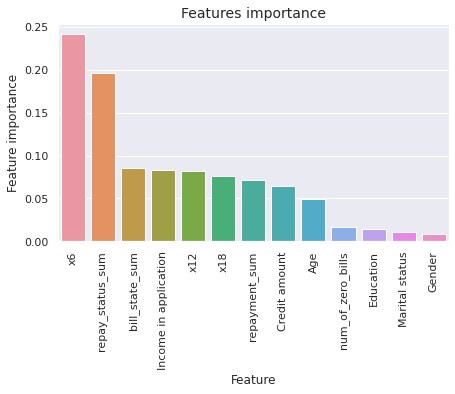

In [ ]:
clf_forest = RandomForestClassifier(random_state = 0,criterion = 'entropy', max_depth = 11,min_impurity_decrease= 0,n_estimators = 100)
clf_forest.fit(X_train,y_train)
y_pred = clf_forest.predict(X_test)
print("Test accuracy of Random Forest: ",accuracy_score(y_test,y_pred))
AUC = roc_auc_score(y_test,y_pred)
print("ROC AUC scores",AUC)

# Automatic feature selection, used recursively
sel = SelectFromModel(clf_forest)
sel.fit(X_train, y_train)
tehhe = np.where(sel.get_support()== True)[0].astype(int)
selected_features = [select_all[i] for i in tehhe]
print("Automatic selected important features of Random Forest: ", selected_features)

tmp = pd.DataFrame({'Feature': select_all, 'Feature importance': clf_forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### **Final Logistic Regression Model**

In [ ]:
# Select features

feature_selection = ['x6']
y = np.array(response)
X = np.array(full_features[feature_selection])
#X = np.concatenate((encoded_categorical,X),axis = 1)
#X = np.concatenate((encoded_categorical,PCA_encoded,X),axis = 1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True)

In [ ]:
# The final Calibrated logistic regression
# See below for calibration results

clf_logistic = LogisticRegression(random_state=0,multi_class = 'ovr',max_iter = 100, solver = 'newton-cg')
CV_logistic = cross_val_score(clf_logistic, X_train, y_train, cv=10)
clf_logistic.fit(X_train,y_train)
y_pred = clf_logistic.predict(X_test)
AUC = roc_auc_score(y_test,y_pred)


In [ ]:
print("Cross_val_score of Logistic Regression: ",np.mean(CV_logistic))
print("Test accuracy of Logistic Regression: ",accuracy_score(y_test,y_pred))
print("ROC AUC scores",AUC)


Cross_val_score of Logistic Regression:  0.8192127773661758
Test accuracy of Logistic Regression:  0.8155405405405406
ROC AUC scores 0.6524304407024777


In [ ]:
# Automatic feature selection, used recursively
sel = SelectFromModel(clf_logistic)
sel.fit(X_train, y_train)
sel.get_support()
tehhe = np.where(sel.get_support()== True)[0].astype(int)
selected_features = [feature_selection[i] for i in tehhe]

Automatic selected important features:  ['x6']


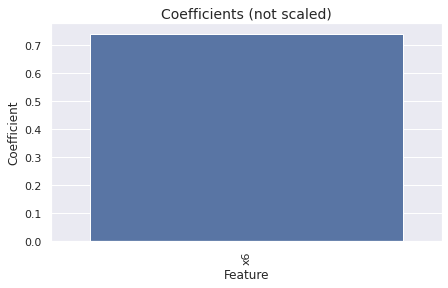

In [ ]:
print("Automatic selected important features: ", selected_features)

# Keep in mind that the coefficients aren't scaled to the value size
tmp = pd.DataFrame({'Feature': feature_selection, 'Coefficient': clf_logistic.coef_[0]})
tmp = tmp.sort_values(by='Coefficient',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Coefficients (not scaled)',fontsize=14)
s = sns.barplot(x='Feature',y='Coefficient',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

### **Final Random Forest Model**

In [ ]:
# Select features

feature_selection =  ['x6', 'repay_status_sum']
y = np.array(response)
X = np.array(full_features[feature_selection])
#X = np.concatenate((encoded_categorical,X),axis = 1)
#X = np.concatenate((encoded_categorical,PCA_encoded,X),axis = 1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True)

In [ ]:
# The final Calibrated random forest
# See below for calibration results

clf_forest = RandomForestClassifier(random_state = 0,criterion = 'entropy', max_depth = 8,min_impurity_decrease= 0,n_estimators = 300)
CV_score = cross_val_score(clf_forest, X_train, y_train, cv=10)

print("Cross_val_score of Random Forest: ", np.mean(CV_score))

clf_forest.fit(X_train,y_train)
y_pred = clf_forest.predict(X_test)

print("Test accuracy of Random Forest: ",accuracy_score(y_test,y_pred))

AUC = roc_auc_score(y_test,y_pred)

print("ROC AUC scores",AUC)

Cross_val_score of Random Forest:  0.8199635140209681
Test accuracy of Random Forest:  0.8202702702702702
ROC AUC scores 0.6697603278024364


Automatic selected important features of Random Forest:  ['repay_status_sum']


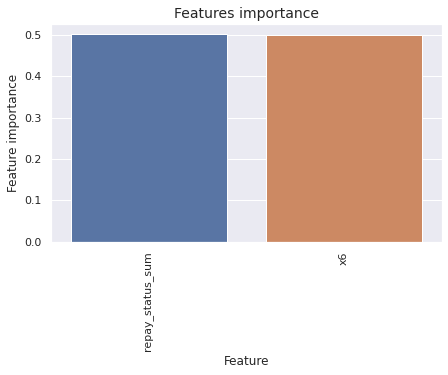

In [ ]:
# Automatic feature selection, used recursively
sel = SelectFromModel(clf_forest)
sel.fit(X_train, y_train)
tehhe = np.where(sel.get_support()== True)[0].astype(int)
selected_features = [feature_selection[i] for i in tehhe]
print("Automatic selected important features of Random Forest: ", selected_features)


tmp = pd.DataFrame({'Feature': feature_selection, 'Feature importance': clf_forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### **Calibration of Logistic Regression**

In [ ]:
# Select features

feature_selection = ['x6']
y = np.array(response)
X = np.array(full_features[feature_selection])
#X = np.concatenate((encoded_categorical,X),axis = 1)
#X = np.concatenate((encoded_categorical,PCA_encoded,X),axis = 1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True)

In [ ]:
# Calibrate Iterations

clf_logistic = LogisticRegression(random_state=0)
cross_val_score(clf_logistic, X_train, y_train, cv=10)

solvers = ['newton-cg','lbfgs','liblinear','sag','saga']
iterations = [50,100,150,200,250]
n_solver = len(solvers)
n_iter = len(iterations)
iter_mean = np.zeros((n_solver,n_iter))
iter_std = np.zeros((n_solver,n_iter))

for i in range(n_solver):
  for j in range(n_iter):
    clf = LogisticRegression(random_state=0, solver= solvers[i], max_iter = iterations[j],multi_class = 'ovr')
    CV = cross_val_score(clf, X_train, y_train, cv=10)

    iter_mean[i,j] = np.mean(CV)
    iter_std[i,j] = np.std(CV)


Text(0, 0.5, 'cross_val_score')

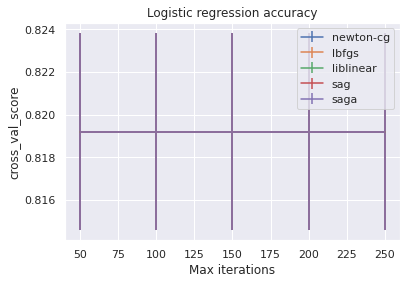

In [ ]:
for i in range(n_solver):
  plt.errorbar(iterations,iter_mean[i],yerr = iter_std[i])

plt.title('Logistic regression accuracy')
plt.legend(solvers)
plt.xlabel('Max iterations')
plt.ylabel('cross_val_score')

# All solvers yield the exact same result...

In [ ]:
# Calibrate Tolerance

clf_logistic = LogisticRegression(random_state=0)
cross_val_score(clf_logistic, X_train, y_train, cv=10)

solvers = ['newton-cg','lbfgs','liblinear','sag','saga']
tols = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
n_solver = len(solvers)
n_tol = len(tols)
mean = np.zeros((n_solver,n_tol))
std = np.zeros((n_solver,n_tol))

for i in range(n_solver):
  for j in range(n_tol):
    clf = LogisticRegression(random_state=0, solver= solvers[i], tol = tols[j])
    CV = cross_val_score(clf, X_train, y_train, cv=10)

    mean[i,j] = np.mean(CV)
    std[i,j] = np.std(CV)


Text(0, 0.5, 'cross_val_score')

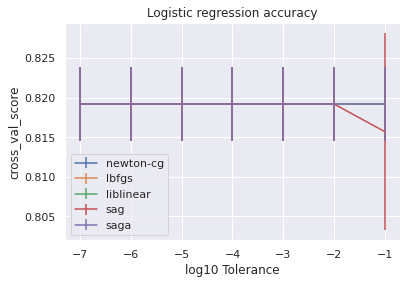

In [ ]:
log_tols = np.log10(tols)
for i in range(n_solver):
  plt.errorbar(log_tols,mean[i],yerr = std[i])

plt.title('Logistic regression accuracy')
plt.legend(solvers)
plt.xlabel('log10 Tolerance')
plt.ylabel('cross_val_score')

# Pretty much the same again

### **Calibration of Random Forest**

In [ ]:
# Select features

feature_selection =  ['x6', 'repay_status_sum']
y = np.array(response)
X = np.array(full_features[feature_selection])
#X = np.concatenate((encoded_categorical,X),axis = 1)
#X = np.concatenate((encoded_categorical,PCA_encoded,X),axis = 1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True)

In [ ]:
# Calibrate max_depths
max_depths = [3,5,8,11,14,17]
gini_mean = []
gini_std = []
entropy_mean = []
entropy_std = []
for MAX_DEPTH in max_depths:
  clf_gini = RandomForestClassifier(random_state = 0,criterion = 'gini', max_depth = MAX_DEPTH)
  CV = cross_val_score(clf_gini, X_train, y_train, cv=10)
  gini_mean.append(np.mean(CV))
  gini_std.append(np.std(CV))

  clf_entropy = RandomForestClassifier(random_state = 0,criterion = 'entropy', max_depth = MAX_DEPTH)
  CV = cross_val_score(clf_entropy, X_train, y_train, cv=10)
  entropy_mean.append(np.mean(CV))
  entropy_std.append(np.std(CV))

Text(0, 0.5, 'cross_val_score')

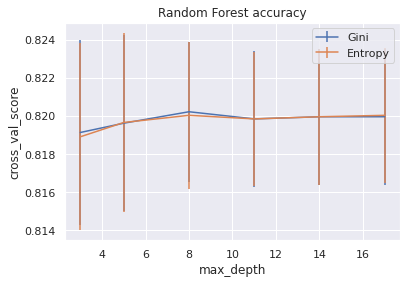

In [ ]:
plt.errorbar(max_depths,gini_mean,yerr = gini_std)
plt.errorbar(max_depths,entropy_mean,yerr = entropy_std)
plt.title('Random Forest accuracy')
plt.legend(['Gini','Entropy'])
plt.xlabel('max_depth')
plt.ylabel('cross_val_score')

In [ ]:
# Calibrate min_impurity_decrease
min_impurity_decreases = [0,0.001,0.005,0.01,0.05,0.1,0.5]
gini_mean = []
gini_std = []
entropy_mean = []
entropy_std = []
for MIN_IMPURITY in min_impurity_decreases:
  clf_gini = RandomForestClassifier(random_state = 0,criterion = 'gini', max_depth = 11, min_impurity_decrease= MIN_IMPURITY)
  CV = cross_val_score(clf_gini, X_train, y_train, cv=10)
  gini_mean.append(np.mean(CV))
  gini_std.append(np.std(CV))

  clf_entropy = RandomForestClassifier(random_state = 0,criterion = 'entropy', max_depth = 11,min_impurity_decrease= MIN_IMPURITY)
  CV = cross_val_score(clf_entropy, X_train, y_train, cv=10)
  entropy_mean.append(np.mean(CV))
  entropy_std.append(np.std(CV))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'cross_val_score')

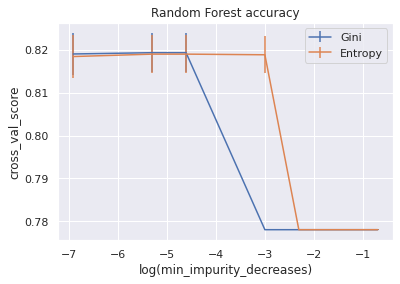

In [ ]:
plt.errorbar(np.log(min_impurity_decreases),gini_mean,yerr = gini_std)
plt.errorbar(np.log(min_impurity_decreases),entropy_mean,yerr = entropy_std)
plt.title('Random Forest accuracy')
plt.legend(['Gini','Entropy'])
plt.xlabel('log(min_impurity_decreases)')
plt.ylabel('cross_val_score')

In [ ]:
# Calibrate n_estimators
n_estimators = [100,200,300,400,500]
gini_mean = []
gini_std = []
entropy_mean = []
entropy_std = []
for N_ESTIMATOR in n_estimators:
  clf_gini = RandomForestClassifier(random_state = 0,criterion = 'gini', max_depth = 11, min_impurity_decrease= 0,n_estimators=N_ESTIMATOR)
  CV = cross_val_score(clf_gini, X_train, y_train, cv=10)
  gini_mean.append(np.mean(CV))
  gini_std.append(np.std(CV))

  clf_entropy = RandomForestClassifier(random_state = 0,criterion = 'entropy', max_depth = 11,min_impurity_decrease= 0,n_estimators=N_ESTIMATOR)
  CV = cross_val_score(clf_entropy, X_train, y_train, cv=10)
  entropy_mean.append(np.mean(CV))
  entropy_std.append(np.std(CV))

Text(0, 0.5, 'cross_val_score')

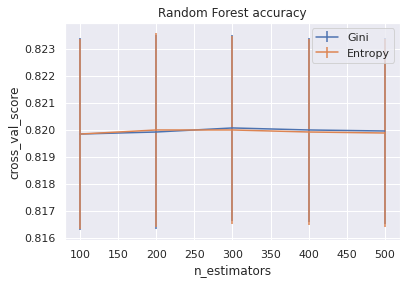

In [ ]:
plt.errorbar(n_estimators,gini_mean,yerr = gini_std)
plt.errorbar(n_estimators,entropy_mean,yerr = entropy_std)
plt.title('Random Forest accuracy')
plt.legend(['Gini','Entropy'])
plt.xlabel('n_estimators')
plt.ylabel('cross_val_score')